<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB2] - CNN with GTSRB dataset - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first results
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :**  You must have previously generated the enhanced datasets with the GTS1 notebook.

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('GTSRB2')

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : GTS2
Run time             : Thursday 17 December 2020, 17:05:29
TensorFlow version   : 2.1.0
Keras version        : 2.2.4-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Running mode         : full
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [2]:
%%time

def read_dataset(dataset_dir, name):
    '''Reads h5 dataset from dataset_dir
    Args:
        dataset_dir : datasets dir
        name        : dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename=f'{dataset_dir}/GTSRB/enhanced/{name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]

    # ---- done
    print('Dataset "{}" is loaded. ({:.1f} Mo)\n'.format(name,os.path.getsize(filename)/(1024*1024)))
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = read_dataset(datasets_dir, 'set-24x24-L')

Dataset "set-24x24-L" is loaded. (228.8 Mo)

CPU times: user 3.56 ms, sys: 82.5 ms, total: 86 ms
Wall time: 216 ms


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


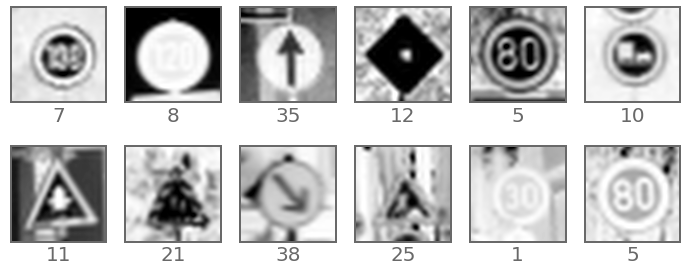

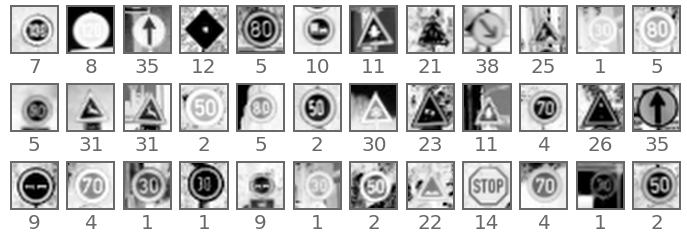

In [3]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [4]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [5]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [6]:
model = get_model_v1(lx,ly,lz)

model.summary()

# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=72)
# display(img)

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

**Train it :**

In [7]:
%%time

batch_size = 64
epochs     = 5

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (x_test, y_test))

Train on 39209 samples, validate on 12630 samples
Epoch 1/5
39209/39209 [==============================] - 4s 110us/sample - loss: 1.2184 - accuracy: 0.6623 - val_loss: 0.4307 - val_accuracy: 0.8982
Epoch 2/5
39209/39209 [==============================] - 2s 49us/sample - loss: 0.2259 - accuracy: 0.9349 - val_loss: 0.3110 - val_accuracy: 0.9282
Epoch 3/5
39209/39209 [==============================] - 2s 49us/sample - loss: 0.1301 - accuracy: 0.9622 - val_loss: 0.2643 - val_accuracy: 0.9382
Epoch 4/5
39209/39209 [==============================] - 2s 49us/sample - loss: 0.0871 - accuracy: 0.9742 - val_loss: 0.2500 - val_accuracy: 0.9389
Epoch 5/5
39209/39209 [==============================] - 2s 49us/sample - loss: 0.0666 - accuracy: 0.9803 - val_loss: 0.2121 - val_accuracy: 0.9482
CPU times: user 12.3 s, sys: 1.89 s, total: 14.2 s
Wall time: 12.2 s


**Evaluate it :**

In [8]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9482


In [9]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2121
Test accuracy  : 0.9482


In [10]:
pwk.end()

End time is : Thursday 17 December 2020, 17:05:50
Duration is : 00:00:20 263ms
This notebook ends here


<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>